# 7. 卡尔曼滤波器的数学原理

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

如果你已经读到这里，我希望你觉得卡尔曼滤波器的可怕名声有些不太应该。当然，我有忽略了一些方程，但我希望你对实现过程还是比较理解的。其基本概念相当简单——取两个测量值，或者一次测量和一次预测，然后选择输出值介于两者之间。如果你更相信测量值，你的估计会更接近测量值；如果你更相信预测更准确，你的估计会更接近它。这不是什么高深的科学（开个小玩笑——正是这种数学让阿波罗号登月并安全返回了地球！）。

老实说，我一直精心选择问题。对于任意问题，设计卡尔曼滤波器的矩阵可能会非常困难。不过，我并没有搞得太复杂。像牛顿运动方程这样的方程在卡尔曼滤波器的应用中可以轻松计算，而且它们构成了我们想要解决的问题的大部分。

我用代码和推理阐述了概念，而不是数学。但有些主题需要比我目前使用的数学更多。这一章介绍了你在本书后续内容中会用到的数学知识。

# 动态系统建模

动态系统是指其状态（位置、温度等）随时间演变的物理系统。微积分是研究变化值的数学，因此我们使用微分方程来建模动态系统。有些系统无法用微分方程建模，但在本书中我们不会遇到这些系统。

对动态系统建模通常是几门大学课程的主题。在某种程度上，几个学期的普通微分方程和偏微分方程，再加上一门控制系统理论的研究生课程，是无可替代的。如果你是一个业余爱好者，或者在工作中尝试解决一个非常具体的滤波问题，你可能没有时间和/或倾向去花费一年或更长时间来接受这种教育。

幸运的是，我可以介绍足够的理论知识，让我们能够为许多不同的卡尔曼滤波器创建系统方程。我的目标是让你能够阅读一篇论文，并理解得足够透彻，以便实现这些算法。背景数学很深奥，但在实践中，我们最终使用了一些简单的技术。

这是本书中纯数学内容最长的一部分。你需要掌握本节中的所有内容才能理解扩展卡尔曼滤波器（EKF），这是最常见的非线性滤波器。我确实介绍了一些不需要太多数学知识的更现代的滤波器。你可以选择现在快速浏览一遍，如果决定学习EKF再回头来复习。

我们需要首先了解卡尔曼滤波器使用的基本方程和假设。我们试图对现实世界的现象进行建模，那么我们需要考虑什么？

每个物理系统都有一个过程。例如，以特定速度行驶的汽车在固定的时间内行驶一定距离，其速度随加速度变化。我们用高中学过的著名的牛顿方程描述了这种行为。

$$
\begin{aligned}
v&=at\\
x &= \frac{1}{2}at^2 + v_0t + x_0
\end{aligned}
$$

一旦我们学了微积分，就能以这种形式看到它们：

$$ \mathbf v = \frac{d \mathbf x}{d t}, 
\quad \mathbf a = \frac{d \mathbf v}{d t} = \frac{d^2 \mathbf x}{d t^2}
$$

典型的汽车跟踪问题会让你计算在恒定速度或加速度下行驶的距离，就像我们在之前的章节中所做的那样。但是，当然我们知道实际情况并不仅限于此。没有汽车会在完美的道路上行驶。路上会有颠簸、风阻，还有山丘会使速度上下波动。

排除最琐碎的问题之外完美地对系统进行建模是不可能的。我们被迫进行简化。在任何时刻$t$，我们说真实状态（比如我们的汽车位置）是来自不完美模型的预测值再加上一些未知的*过程噪声*：

$$
x(t) = x_{pred}(t) + noise(t)
$$

这并不意味着$noise(t)$是我们可以通过分析推导出的函数。这只是一个事实陈述——我们总是可以将真实值描述为预测值加上过程噪声。“噪声”并不意味着随机事件。如果我们在大气中追踪一个抛出的球，并且我们的模型假设球在真空中，那么空气阻力的影响就是在这种情况下的过程噪声。

在接下来的部分，我们将学习将一组高阶微分方程转换为一组一阶微分方程的技巧。在转换后，没有噪声的系统模型是：

$$ \dot{\mathbf x} = \mathbf{Ax}$$

矩阵 $\mathbf A$ 被称为 *系统动态矩阵*，因为它描述了系统的动态。现在我们需要对噪声建模。我们将其称为 $\mathbf w$，并将其添加到方程中。

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf w$$

$\mathbf w$ 这个命名可能让你觉得不太合适，但你很快就会看到，卡尔曼滤波器假设是*白噪声*。

最后，我们需要考虑系统中的任何输入。我们假设有一个输入 $\mathbf u$，并且存在一个线性模型来定义该输入如何改变系统。例如，踩汽车油门会加速汽车，重力会使球下落。这两者都是控制输入。我们需要一个矩阵 $\mathbf B$ 将 $u$ 转换为对系统的影响，并将其添加到我们的方程中：

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu} + \mathbf{w}$$

这就是其中一个方程。卡尔曼博士尝试解决的方程之一，他找到了一个最优的估计器，如果我们假设了 $\mathbf w$ 的某些特性。

# 动态系统状态空间的表达

我们推导出了这个方程：

$$ \dot{\mathbf x} = \mathbf{Ax}+ \mathbf{Bu} + \mathbf{w}$$

然而，我们对 $\mathbf x$ 本身感兴趣，而不是它的导数。暂时忽略噪声，我们希望找到一个递归地以 $t_{k-1}$ 时刻的 $\mathbf x$ 表达 $t_k$ 时刻 $\mathbf x$ 值的方程：

$$\mathbf x(t_k) = \mathbf F(\Delta t)\mathbf x(t_{k-1}) + \mathbf B(t_k)\mathbf u (t_k)$$

惯例允许我们将 $\mathbf x(t_k)$ 写成 $\mathbf x_k$，这表示 $t$ 的第 $k$ 个值时 $\mathbf x$ 的值。

$$\mathbf x_k = \mathbf{Fx}_{k-1} + \mathbf B_k\mathbf u_k$$

矩阵 $\mathbf F$ 是我们熟悉的 *状态转移矩阵*，因为它能够在离散时间步之间转换状态的值。它与系统动态矩阵 $\mathbf A$ 非常相似。不同之处在于 $\mathbf A$ 模拟一组线性微分方程，是连续的。而 $\mathbf F$ 是离散的，表示一组线性方程（不是微分方程），它在离散的时间步长 $\Delta t$ 内将 $\mathbf x_{k-1}$ 转换为 $\mathbf x_k$。

找到这个矩阵通常是相当困难的。方程 $\dot x = v$ 是最简单的微分方程，我们可以轻松地对其进行积分：

$$ \int\limits_{x_{k-1}}^{x_k}  \mathrm{d}x = \int\limits_{0}^{\Delta t} v\, \mathrm{d}t $$
$$x_k-x_{k-1} = v \Delta t$$
$$x_k = v \Delta t + x_{k-1}$$

这个方程是*递归*的：我们根据其在 $k-1$ 时刻的值来计算 $k$ 时刻的 $x$ 值。这种递归形式使我们能够将系统（过程模型）表示为卡尔曼滤波器所需的形式：

$$\begin{aligned}
\mathbf x_k &= \mathbf{Fx}_{k-1}  \\
&= \begin{bmatrix} 1 & \Delta t \\ 0 & 1\end{bmatrix}
\begin{bmatrix}x_{k-1} \\ \dot x_{k-1}\end{bmatrix}
\end{aligned}$$

我们之所以能这样做，只是因为 $\dot x = v$ 是可能的最简单的微分方程。几乎所有其他物理系统中的微分方程都更复杂，无法采用这种方法。

*状态空间* 方法在阿波罗任务时期变得流行，这在很大程度上要归功于卡尔曼博士的工作。其思想很简单。用一组 $n$ 阶微分方程对系统进行建模。将它们转换为等价的一阶微分方程集合。将它们放入前面章节中使用的向量-矩阵形式：$\dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu}$。一旦达到这种形式，我们就会使用几种技术将这些线性微分方程转换为递归方程：

$$ \mathbf x_k = \mathbf{Fx}_{k-1} + \mathbf B_k\mathbf u_k$$

一些书籍将状态转移矩阵称为*基本矩阵*。许多书籍使用 $\mathbf \Phi$ 而不是 $\mathbf F$。在很大程度上基于控制理论的资料倾向于使用这些形式。

这些被称为*状态空间*方法，因为我们是用系统状态来表达微分方程的解。

# 将高阶微分方程转化为一阶微分方程

许多物理系统的模型需要带有控制输入 $u$ 的二阶或更高阶微分方程：

$$a_n \frac{d^ny}{dt^n} + a_{n-1} \frac{d^{n-1}y}{dt^{n-1}} +  \dots + a_2 \frac{d^2y}{dt^2} + a_1 \frac{dy}{dt} + a_0 = u$$

状态空间方法需要一阶方程。任何高阶方程组都可以通过为导数定义额外的变量，然后进行求解来化简为一阶方程。

我们来做一个例子。给定系统 $\ddot{x} - 6\dot x + 9x = u$，找到等价的一阶方程。我用点符号表示时间导数以便更清楚。

第一步是将最高阶的项隔离到方程的一侧。

$$\ddot{x} = 6\dot x - 9x + u$$

我们定义两个新变量:

$$\begin{aligned} x_1(t) &= x \\
x_2(t) &= \dot x
\end{aligned}$$

现在我们将这些代入原方程并求解。解得到一组关于这些新变量的一阶方程。通常为了方便起见，我们在符号表示中省略 $(t)$。

我们知道 $\dot x_1 = x_2$，以及 $\dot x_2 = \ddot{x}$。因此

$$\begin{aligned}
\dot x_2 &= \ddot{x} \\
         &= 6\dot x - 9x + u\\
         &= 6x_2-9x_1 + u
\end{aligned}$$

因此，我们得到的一阶方程组是：

$$\begin{aligned}\dot x_1 &= x_2 \\
\dot x_2 &= 6x_2-9x_1 + u\end{aligned}$$

练习一段时间你就能熟练掌握了。将最高阶项隔离出来，定义一个新变量及其导数，然后进行代换。

# 一阶微分方程的状态空间形式

从前一节定义的新变量代入：

$$\frac{dx_1}{dt} = x_2,\,  
\frac{dx_2}{dt} = x_3, \, ..., \, 
\frac{dx_{n-1}}{dt} = x_n$$

代入一阶方程得到：

$$\frac{dx_n}{dt} = \frac{1}{a_n}\sum\limits_{i=0}^{n-1}a_ix_{i+1} + \frac{1}{a_n}u
$$

使用向量-矩阵表示法，我们有：

$$\begin{bmatrix}\frac{dx_1}{dt} \\ \frac{dx_2}{dt} \\ \vdots \\ \frac{dx_n}{dt}\end{bmatrix} = 
\begin{bmatrix}\dot x_1 \\ \dot x_2 \\ \vdots \\ \dot x_n\end{bmatrix}=
\begin{bmatrix}0 & 1 & 0 &\cdots & 0 \\
0 & 0 & 1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
-\frac{a_0}{a_n} & -\frac{a_1}{a_n} & -\frac{a_2}{a_n} & \cdots & -\frac{a_{n-1}}{a_n}\end{bmatrix}
\begin{bmatrix}x_1 \\ x_2 \\ \vdots \\ x_n\end{bmatrix} + 
\begin{bmatrix}0 \\ 0 \\ \vdots \\ \frac{1}{a_n}\end{bmatrix}u$$

然后我们将其写作 $\dot{\mathbf x} = \mathbf{Ax} + \mathbf{B}u$。

# 寻找时不变系统的基本矩阵

我们用状态空间形式表示系统方程，其中

$$ \dot{\mathbf x} = \mathbf{Ax}$$

其中 $\mathbf A$ 是系统动态矩阵，我们想要找到*基本矩阵* $\mathbf F$，它用以下方程在时间间隔 $\Delta t$ 内传播状态 $\mathbf x$：

$$\begin{aligned}
\mathbf x(t_k) = \mathbf F(\Delta t)\mathbf x(t_{k-1})\end{aligned}$$

换句话说，$\mathbf A$ 是一组连续微分方程，而我们需要 $\mathbf F$ 是一组离散线性方程，用于计算 $\mathbf A$ 在离散时间步长内的变化。

通常会省略 $t_k$ 和 $(\Delta t)$，使用记号

$$\mathbf x_k = \mathbf {Fx}_{k-1}$$

总的来说，有三种常用的方法来为卡尔曼滤波器找到这个矩阵。最常用的技术是矩阵指数。线性时不变理论，也称为LTI系统理论，是第二种技术。最后，还有数值技术。你可能知道其他方法，但在卡尔曼滤波器的文献和实践中，最常遇到的就是这三种。

# 矩阵指数

求解方程 $\frac{dx}{dt} = kx$ 可以通过以下步骤找到：

$$\begin{gathered}\frac{dx}{dt} = kx \\
\frac{dx}{x} = k\, dt \\
\int \frac{1}{x}\, dx = \int k\, dt \\
\log x = kt + c \\
x = e^{kt+c} \\
x = e^ce^{kt} \\
x = c_0e^{kt}\end{gathered}$$

当 $t=0$ 时，$x=x_0$。将这些代入上述方程。

$$\begin{gathered}x_0 = c_0e^{k(0)} \\
x_0 = c_01 \\
x_0 = c_0 \\
x = x_0e^{kt}\end{gathered}$$

用类似的数学方法，一阶方程的解是：

$$\dot{\mathbf x} = \mathbf{Ax} ,\, \, \, \mathbf x(0) = \mathbf x_0$$

其中 $\mathbf A$ 是一个常数矩阵，是

$$\mathbf x = e^{\mathbf At}\mathbf x_0$$

将 $F = e^{\mathbf At}$ 代入，我们可以写成

$$\mathbf x_k = \mathbf F\mathbf x_{k-1}$$

这就是我们要找的形式！我们将寻找基本

矩阵的问题简化为寻找 $e^{\mathbf At}$ 的值。

$e^{\mathbf At}$ 被称为[矩阵指数](https://en.wikipedia.org/wiki/Matrix_exponential)。它可以用以下幂级数计算：

$$e^{\mathbf At} = \mathbf{I} + \mathbf{A}t  + \frac{(\mathbf{A}t)^2}{2!} + \frac{(\mathbf{A}t)^3}{3!} + ... $$

这个级数是通过对 $e^{\mathbf At}$ 进行泰勒级数展开得到的，我在这里不会详细介绍。

让我们利用这个来找到牛顿方程的解。假设速度为常数，用 $v$ 代替 $\dot x$，我们得到线性矩阵-向量形式

$$\begin{bmatrix}\dot x \\ \dot v\end{bmatrix} =\begin{bmatrix}0&1\\0&0\end{bmatrix} \begin{bmatrix}x \\ v\end{bmatrix}$$

这是一个一阶微分方程，所以我们可以设 $\mathbf{A}=\begin{bmatrix}0&1\\0&0\end{bmatrix}$，并解下面的方程。我将间隔 $\Delta t$ 替换为 $t$，以强调基本矩阵是离散的：

$$\mathbf F = e^{\mathbf A\Delta t} = \mathbf{I} + \mathbf A\Delta t  + \frac{(\mathbf A\Delta t)^2}{2!} + \frac{(\mathbf A\Delta t)^3}{3!} + ... $$

如果你进行乘法运算，你会发现 $\mathbf{A}^2=\begin{bmatrix}0&0\\0&0\end{bmatrix}$，这意味着所有更高幂次的 $\mathbf{A}$ 也都是 $\mathbf{0}$。因此，我们得到了一个精确的答案，而不需要无穷多个项：

$$
\begin{aligned}
\mathbf F &=\mathbf{I} + \mathbf A \Delta t + \mathbf{0} \\
&= \begin{bmatrix}1&0\\0&1\end{bmatrix} + \begin{bmatrix}0&1\\0&0\end{bmatrix}\Delta t\\
&= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\end{aligned}$$

我们将这个代入 $\mathbf x_k= \mathbf{Fx}_{k-1}$ 得到

$$
\begin{aligned}
x_k &=\begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}x_{k-1}
\end{aligned}$$

这个矩阵正是我们在**多元卡尔曼滤波器**章节中对恒定速度卡尔曼滤波器进行解析推导得到的矩阵。

SciPy 的 linalg 模块包括一个用于计算矩阵指数的例程 `expm()`。它并不使用泰勒级数方法，而是使用[佩德算法近似](https://en.wikipedia.org/wiki/Pad%C3%A9_approximant)。有许多（至少19种）计算矩阵指数的方法，所有这些方法都存在数值困难[1]。你应该注意到这些问题，特别是当 $\mathbf A$ 很大时。如果你搜索“佩德算法矩阵指数”，你会找到许多致力于解决这个问题的论文。

在实践中，对于卡尔曼滤波器，我们通常只考虑泰勒级数的前两项，因此这可能不会成为你关注的问题。但不要假设我对这个问题的处理就是完整的，然后盲目尝试将这种技术用于其他问题，而不对这种技术的性能进行数值分析。有趣的是，解决 $e^{\mathbf At}$ 的一个受欢迎的方法是使用广义的常微分方程求解器。换句话说，他们做的与我们相反——将 $\mathbf A$ 转换成一组微分方程，然后使用数值技术求解这组方程！

这里是使用 `expm()` 解决 $e^{\mathbf At}$ 的一个例子。

In [3]:
import numpy as np
from scipy.linalg import expm

dt = 0.1
A = np.array([[0, 1], 
              [0, 0]])
expm(A*dt)

array([[1. , 0.1],
       [0. , 1. ]])

# 时不变系统

如果系统的行为取决于时间，我们可以说一个动态系统由一阶微分方程描述：

$$ g(t) = \dot x$$

然而，如果系统是*时不变*的，方程的形式则为：

$$ f(x) = \dot x$$

什么是*时不变*呢？如果你在时间 $t$ 输入信号 $x$，它将输出一些信号 $f(x)$。如果你在时间 $t + \Delta t$ 进行输入，输出信号将是相同的 $f(x)$，只是在时间上有所偏移。

一个反例是 $x(t) = \sin(t)$，其系统为 $f(x) = t\,  x(t) = t \sin(t)$。这不是时不变的；由于乘以 t，不同时间的值会有所不同。飞机也不是时不变的。如果你在稍后的时间对飞机进行控制输入，它的行为将会不同，因为它将消耗燃料，因此失去重量。较轻的重量会导致不同的行为。

我们可以通过对每一边进行积分来解这些方程。我之前展示了对时不变系统 $v = \dot x$ 进行积分。然而，对时不变方程 $\dot x = f(x)$ 进行积分并不那么直接。使用*分离变量*技术，我们除以 $f(x)$ 并将 $dt$ 项移到右边，以便对每一边进行积分：


$$\begin{gathered}
\frac{dx}{dt} = f(x) \\
\int^x_{x_0} \frac{1}{f(x)} dx = \int^t_{t_0} dt
\end{gathered}$$

如果我们令 $F(x) = \int \frac{1}{f(x)} dx$，我们会得到

$$F(x) - F(x_0) = t-t_0$$

然后我们解出 x，得到

$$\begin{gathered}
F(x) = t - t_0 + F(x_0) \\
x = F^{-1}[t-t_0 + F(x_0)]
\end{gathered}$$

换句话说，我们需要找到 $F$ 的反函数。这并不是简单的问题，在STEM教育中有很多课程专门致力于找到这个棘手的解析解。

然而，它们都是一些技巧，许多简单形式的 $f(x)$ 要么没有闭合形式的解，要么具有极大的困难。因此，实际工程师转向状态空间方法来寻找近似解。

矩阵指数的优势在于我们可以用它来处理任意一组*时不变*的微分方程。然而，即使方程并非时不变，我们通常也会使用这种技术。例如，随着飞机飞行，它会燃烧燃料并减轻重量。然而，在一秒钟内失重很小，因此系统在这个时间步长上几乎是线性的。只要时间步长很短，我们的答案仍然会相当准确。

# 例子：质量-弹簧-阻尼器模型

假设我们想要追踪弹簧上的一个质量，并连接到阻尼器，比如汽车的悬挂系统。其运动方程是 $m$ 为质量，$k$ 为弹簧常数，$c$ 为阻尼力，在某个输入 $u$ 下的运动方程为：

$$m\frac{d^2x}{dt^2} + c\frac{dx}{dt} +kx = u$$

为了符号的简便，我将其写成：

$$m\ddot x + c\dot x + kx = u$$

为了方便记号，我省略了 $(t)$。我可以通过设定 $x_1(t)=x(t)$ 来将其转化为一组一阶方程，并进行如下代换：

$$\begin{aligned}
x_1 &= x \\
x_2 &= \dot x_1 \\
\dot x_2 &= \ddot x_1 = \ddot x
\end{aligned}$$

这里常见的做法是省略了 $(t)$ 以方便记号。这给出了方程：

$$m\dot x_2 + c x_2 +kx_1 = u$$

解出 $\dot x_2$，我们得到一个一阶方程：

$$\dot x_2 = -\frac{c}{m}x_2 - \frac{k}{m}x_1 + \frac{1}{m}u$$

我们将其写成矩阵形式：

$$\begin{bmatrix} \dot x_1 \\ \dot x_2 \end{bmatrix} = 
\begin{bmatrix}0 & 1 \\ -\frac{k}{m} & -\frac{c}{m} \end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + 
\begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix}u$$

现在我们使用矩阵指数来找到状态转移矩阵：

$$\Phi(t) = e^{\mathbf At} = \mathbf{I} + \mathbf At  + \frac{(\mathbf At)^2}{2!} + \frac{(\mathbf At)^3}{3!} + ... $$

前两项给出：

$$\mathbf F = \begin{bmatrix}1 & t \\ -\frac{k}{m} t & 1-\frac{c}{m} t \end{bmatrix}$$

这可能给出足够的精度，但也可能不够。你可以通过计算对应常数的 $\frac{(\mathbf At)^2}{2!}$ 并观察这个矩阵对结果的贡献来检验这一点。

# 线性时不变理论

[*线性时不变理论*](https://en.wikipedia.org/wiki/LTI_system_theory)，也称为LTI系统理论，为我们提供了一种使用逆拉普拉斯变换来找到 $\Phi$ 的方法。我在这本书中不会使用拉普拉斯变换。LTI系统理论告诉我们：

$$ \Phi(t) = \mathcal{L}^{-1}[(s\mathbf{I} - \mathbf{A})^{-1}]$$

我没有打算深入讨论这个问题，只是说一下拉普拉斯变换 $\mathcal{L}$ 将信号转换为一个不包括时间的空间 $s$，但找到上述方程的解并不简单。如果你感兴趣，可以参考维基百科上关于LTI系统理论的文章进行了解。我提到LTI是因为你会发现一些文献使用它来为复杂的问题设计卡尔曼滤波器的矩阵。

# 数值解

最后，还有数值技术来找到 $\mathbf F$。随着滤波器变得更大，找到解析解变得非常繁琐（尽管像SymPy这样的包使其更容易）。C. F. van Loan [2] 发展了一种技术来数值计算 $\Phi$ 和 $\mathbf Q$。给定连续模型

$$ \dot x = Ax + Gw$$

其中 $w$ 是单位白噪声，van Loan 的方法计算出 $\mathbf F_k$ 和 $\mathbf Q_k$。

我在 `FilterPy` 中实现了 van Loan 的方法。你可以这样使用：

```python
from filterpy.common import van_loan_discretization

A = np.array([[0., 1.], [-1., 0.]])
G = np.array([[0.], [2.]]) # white noise scaling
F, Q = van_loan_discretization(A, G, dt=0.1)
```

在 *数值积分的差分方程* 部分，我介绍了在卡尔曼滤波中非常常用的另一种替代方法。

# 过程噪声矩阵的设计

通常来说，设计 $\mathbf Q$ 矩阵是卡尔曼滤波器设计中最困难的部分之一。这是由于几个因素造成的。首先，需要对信号理论有良好的基础。其次，我们试图对我们知之甚少的某些事物中的噪声进行建模。想象一下试图为抛出的棒球建模过程噪声。我们可以将其建模为在空气中运动的一个球体，但这留下了许多未知因素——球的旋转和旋转衰减、带缝球的阻力系数、风力和空气密度的影响等等。我们为给定的过程模型开发了精确的数学解的方程，但由于过程模型不完整，$\mathbf Q$ 的结果也将不完整。这对卡尔曼滤波器的行为有很多影响。如果 $\mathbf Q$ 太小，滤波器将对其预测模型过于自信，并偏离实际解。如果 $\mathbf Q$ 太大，滤波器将受到测量中的噪声的不当影响，并表现不佳。在实践中，我们花费大量时间运行模拟并评估收集的数据，以尝试选择适当的 $\mathbf Q$ 值。但让我们首先看看数学原理。

假设一个运动系统——可以使用牛顿运动方程建模的某个系统。我们可以对这个过程作出几种不同的假设。

我们一直在使用一个过程模型：

$$ \dot{\mathbf x} = \mathbf{Ax} + \mathbf{Bu} + \mathbf{w}$$

其中 $\mathbf{w}$ 是过程噪声。运动系统是*连续*的——它们的输入和输出可以在任意时间点变化。然而，我们的卡尔曼滤波器是*离散*的（卡尔曼滤波器有连续形式，但我们在本书中不涉及）。我们以固定间隔对系统进行采样。因此，我们必须找到上述方程中噪声项的离散表示。这取决于我们对噪声行为的假设。我们将考虑两种不同的噪声模型。

# 连续白噪声模型

我们使用牛顿方程来建模运动系统。我们要么使用位置和速度，要么使用位置、速度和加速度作为系统的模型。我们可以进一步推广，比如可以模拟加加速度、跃度、猛度等。通常我们不这样做，因为超出实际系统动力学范围的项会降低估计的准确性。

假设我们需要对位置、速度和加速度进行建模。然后，我们可以假设每个离散时间步长内加速度是恒定的。当然，系统中存在过程噪声，因此实际上加速度并不是恒定的。由于未建模的外部力会随时间改变被跟踪对象的加速度。在这一部分，我们将假设加速度通过连续时间的零均值白噪声 $w(t)$ 发生变化。换句话说，我们假设速度的微小变化随时间平均为0（零均值）。

由于噪声在不断变化，我们需要进行积分，以获得我们选择的离散化间隔内的离散噪声。我们不会在这里证明，但离散噪声的方程是：

$$\mathbf Q = \int_0^{\Delta t} \mathbf F(t)\mathbf{Q_c}\mathbf F^\mathsf{T}(t) dt$$

其中 $\mathbf{Q_c}$ 是连续噪声。总体思路应该很清楚。$\mathbf F(t)\mathbf{Q_c}\mathbf F^\mathsf{T}(t)$ 是基于我们的过程模型 $\mathbf F(t)$ 在时刻 $t$ 的连续噪声的投影。我们想知道在离散时间间隔 $\Delta t$ 内系统添加了多少噪声，因此我们要对该表达式在区间 $[0, \Delta t]$ 上进行积分。

我们知道牛顿系统的基本矩阵是：

$$F = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

我们将连续噪声定义为:

$$\mathbf{Q_c} = \begin{bmatrix}0&0&0\\0&0&0\\0&0&1\end{bmatrix} \Phi_s$$

其中 $\Phi_s$ 是白噪声的谱密度。这个公式是可以推导出来的，但超出了本书的范围。详细信息请参考任何关于随机过程的标准文本。实际上，我们经常不知道噪声的谱密度，因此这变成了一个“工程”因素——一个我们通过实验调整的数字，直到我们的滤波器按预期运行为止。你可以看到 $\Phi_s$ 乘以的矩阵实际上将功率谱密度分配给了加速度项。这是有道理的；我们假设系统具有恒定的加速度，除了噪声引起的变化。噪声改变了加速度。

我们可以自己进行这些计算，但我更喜欢使用 SymPy 来解方程。

In [4]:
import sympy
from sympy import (init_printing, Matrix, MatMul, 
                   integrate, symbols)

init_printing(use_latex='mathjax')
dt, phi = symbols('\Delta{t} \Phi_s')
F_k = Matrix([[1, dt, dt**2/2],
              [0,  1,      dt],
              [0,  0,       1]])
Q_c = Matrix([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])*phi

Q = integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

# factor phi out of the matrix to make it more readable
Q = Q / phi
MatMul(Q, phi)

⎡         5           4           3⎤      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥      
⎢    20          8           6     ⎥      
⎢                                  ⎥      
⎢         4           3           2⎥      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥⋅\Phiₛ
⎢    8           3           2     ⎥      
⎢                                  ⎥      
⎢         3           2            ⎥      
⎢\Delta{t}   \Delta{t}             ⎥      
⎢──────────  ──────────  \Delta{t} ⎥      
⎣    6           2                 ⎦      

为了完整起见，让我们计算零阶和一阶方程的公式。

In [5]:
F_k = Matrix([[1]])
Q_c = Matrix([[phi]])

print('0th order discrete process noise')
integrate(F_k*Q_c*F_k.T,(dt, 0, dt))

0th order discrete process noise


[\Delta{t}⋅\Phiₛ]

In [6]:
F_k = Matrix([[1, dt],
              [0, 1]])
Q_c = Matrix([[0, 0],
              [0, 1]]) * phi

Q = integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

print('1st order discrete process noise')
# factor phi out of the matrix to make it more readable
Q = Q / phi
MatMul(Q, phi)

1st order discrete process noise


⎡         3           2⎤      
⎢\Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────⎥      
⎢    3           2     ⎥      
⎢                      ⎥⋅\Phiₛ
⎢         2            ⎥      
⎢\Delta{t}             ⎥      
⎢──────────  \Delta{t} ⎥      
⎣    2                 ⎦      

# 分段白噪声模型

另一个噪声模型假设最高阶项（比如加速度）在每个时间段内是恒定的，但在每个时间段内不同，并且这些项在时间段之间是不相关的。换句话说，在每个时间步长上加速度会出现不连续的跃变。这与上述模型略有不同，上述模型假设最后一项受到连续变化的噪声信号的影响。

我们将其建模为：

$$f(x)=Fx+\Gamma w$$

其中 $\Gamma$ 是系统的*噪声增益*，$w$ 是常数分段加速度（或速度、或者加加速度等）。

让我们先看一个一阶系统。在这种情况下，我们有状态转移函数

$$\mathbf{F} = \begin{bmatrix}1&\Delta t \\ 0& 1\end{bmatrix}$$

在一个时间段内，速度的变化将是 $w(t)\Delta t$，而位置的变化将是 $w(t)\Delta t^2/2$，这给出了

$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\end{bmatrix}$$

因此，过程噪声的协方差是

$$Q = \mathbb E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$$

我们可以用 SymPy 来计算它：

In [7]:
var = symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
MatMul(Q, var)

⎡         4           3⎤    
⎢\Delta{t}   \Delta{t} ⎥    
⎢──────────  ──────────⎥    
⎢    4           2     ⎥    
⎢                      ⎥⋅σ²ᵥ
⎢         3            ⎥    
⎢\Delta{t}            2⎥    
⎢──────────  \Delta{t} ⎥    
⎣    2                 ⎦    

第二阶系统遵循相同的数学原理。

$$\mathbf{F} = \begin{bmatrix}1 & \Delta t & {\Delta t}^2/2 \\ 0 & 1 & \Delta t\\ 0& 0& 1\end{bmatrix}$$

在这里，我们假设白噪声是离散时间的维纳过程。这给了我们

$$\Gamma = \begin{bmatrix}\frac{1}{2}\Delta t^2 \\ \Delta t\\ 1\end{bmatrix}$$

这个模型并没有所谓的“真实性”，它只是方便并且提供了良好的结果。例如，我们可以假设噪声作用于加加速度，尽管这会导致更复杂的方程。

因此，过程噪声的协方差是

$$Q = \mathbb E[\Gamma w(t) w(t) \Gamma^\mathsf{T}] = \Gamma\sigma^2_v\Gamma^\mathsf{T}$$

我们可以用 SymPy 来计算它：

In [8]:
var = symbols('sigma^2_v')
v = Matrix([[dt**2 / 2], [dt], [1]])

Q = v * var * v.T

# factor variance out of the matrix to make it more readable
Q = Q / var
MatMul(Q, var)

⎡         4           3           2⎤    
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥    
⎢──────────  ──────────  ──────────⎥    
⎢    4           2           2     ⎥    
⎢                                  ⎥    
⎢         3                        ⎥    
⎢\Delta{t}            2            ⎥    
⎢──────────  \Delta{t}   \Delta{t} ⎥⋅σ²ᵥ
⎢    2                             ⎥    
⎢                                  ⎥    
⎢         2                        ⎥    
⎢\Delta{t}                         ⎥    
⎢──────────  \Delta{t}       1     ⎥    
⎣    2                             ⎦    

这个模型并不能说比连续模型更正确或更错误——它们都是对实际对象发生情况的近似。只有经验和实验才能指导你选择合适的模型。实际上，你通常会发现这两种模型都能提供合理的结果，但其中一种通常比另一种表现更好。

第二个模型的优势在于我们可以用 $\sigma^2$ 来描述噪声，这可以根据运动和我们预期的误差量来描述。而第一个模型则需要我们指定谱密度，这并不是很直观，但它更容易处理时间取样的变化，因为噪声是在时间段内被积累的。然而，这些并不是固定的规则——根据滤波器的性能测试或者你对物理模型行为的了解，可以选择任何一个模型（或自己设计的模型）。

一个经验法则是将 $\sigma$ 设置在 $\frac{1}{2}\Delta a$ 到 $\Delta a$ 之间，其中 $\Delta a$ 是加速度在采样周期之间最大变化的量。在实践中，我们选择一个数值，对数据进行模拟，并选择效果良好的值。

# 使用FilterPy库计算Q

FilterPy提供了几种计算 $\mathbf Q$ 矩阵的例程。`Q_continuous_white_noise()` 函数根据给定的 $\Delta t$ 值和谱密度计算 $\mathbf Q$。

In [9]:
from filterpy.common import Q_continuous_white_noise
from filterpy.common import Q_discrete_white_noise

Q = Q_continuous_white_noise(dim=2, dt=1, spectral_density=1)
print(Q)

[[0.333 0.5  ]
 [0.5   1.   ]]


In [10]:
Q = Q_continuous_white_noise(dim=3, dt=1, spectral_density=1)
print(Q)

[[0.05  0.125 0.167]
 [0.125 0.333 0.5  ]
 [0.167 0.5   1.   ]]


函数 `Q_discrete_white_noise()` 假设噪声采用分段模型来计算 $\mathbf Q$。

In [11]:
Q = Q_discrete_white_noise(2, var=1.)
print(Q)

[[0.25 0.5 ]
 [0.5  1.  ]]


In [12]:
Q = Q_discrete_white_noise(3, var=1.)
print(Q)

[[0.25 0.5  0.5 ]
 [0.5  1.   1.  ]
 [0.5  1.   1.  ]]


# Q的简化

许多处理方法对 $\mathbf Q$ 使用了更简单的形式，将其设置为除了右下角的噪声项之外全为零。这样做是否合理呢？嗯，考虑一下在 $\Delta t$ 很小的情况下 $\mathbf Q$ 的值。

In [13]:
import numpy as np

np.set_printoptions(precision=8)
Q = Q_continuous_white_noise(
    dim=3, dt=0.05, spectral_density=1)
print(Q)
np.set_printoptions(precision=3)

[[0.00000002 0.00000078 0.00002083]
 [0.00000078 0.00004167 0.00125   ]
 [0.00002083 0.00125    0.05      ]]


我们可以看到大多数项都非常小。回想一下，唯一使用这个矩阵的方程是：

$$ \mathbf P=\mathbf{FPF}^\mathsf{T} + \mathbf Q$$

如果相对于 $\mathbf P$，$\mathbf Q$ 的值很小，那么它对 $\mathbf P$ 的计算几乎没有贡献。将 $\mathbf Q$ 设置为零矩阵，除了右下角的项

$$\mathbf Q=\begin{bmatrix}0&0&0\\0&0&0\\0&0&\sigma^2\end{bmatrix}$$

虽然这样做并不正确，但通常是一个有用的近似。如果你在重要应用中这样做，你将不得不进行大量研究，以确保你的滤波器在各种情况下都能正常工作。

如果这样做，‘右下角的项’意味着每个变量中变化最快的项。如果状态是 $x=\begin{bmatrix}x & \dot x & \ddot{x} & y & \dot{y} & \ddot{y}\end{bmatrix}^\mathsf{T}$，那么 $\mathbf Q$ 将是 6x6 的；$\mathbf Q$ 中 $\ddot{x}$ 和 $\ddot{y}$ 的元素都必须设为非零。

# 后验协方差的稳定计算

我提出了计算后验协方差的方程为

$$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$$

严格来说，这是正确的，但这并不是我在`FilterPy`中计算的方法，我使用了*Joseph*方程

$$\mathbf P = (\mathbf I-\mathbf {KH})\mathbf{\bar P}(\mathbf I-\mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T$$

我经常收到邮件和GitHub的问题，声称这种实现是一个bug。这不是bug，我使用它有几个原因。首先，减法 $(\mathbf I - \mathbf{KH})$ 可能由于浮点误差导致矩阵结果不对称。协方差必须是对称的，所以变成不对称通常会导致卡尔曼滤波器发散，甚至因为`NumPy`内置的检查而引发异常。

保持对称性的传统方法是以下公式：

$$\mathbf P = (\mathbf P + \mathbf P^\mathsf T) / 2$$

这是安全的，因为矩阵中所有协方差 $\sigma_{ij} = \sigma_{ji}$。因此，如果它们由于浮点误差发散，此操作会平均两个值的差异。

如果你看一下上面的Joseph形式的方程，你会发现两个项中都有类似 $\mathbf{ABA}^\mathsf T$ 的模式。因此，它们都保持对称性。但这个方程从何而来？为什么我使用它而不是

$$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P} \\
\mathbf P = (\mathbf P + \mathbf P^\mathsf T) / 2$$

让我们从第一原理推导出这个方程。这并不太糟糕，你需要理解推导来理解方程的目的，更重要的是，如果你的滤波器因数值不稳定性而发散，就需要诊断问题。这个推导来自Brown[4]。

首先，一些符号。$\mathbf x$ 是我们系统的真实状态。$\mathbf{\hat x}$ 是我们系统的估计状态 - 后验状态。而 $\mathbf{\bar x}$ 是系统的先验估计。

鉴于此，我们可以定义我们的模型为

$$\mathbf x_{k+1} = \mathbf F_k \mathbf x_k + \mathbf w_k \\
\mathbf z_k = \mathbf H_k \mathbf x_k + \mathbf v_k$$

换句话说，系统的下一个状态 $\mathbf x_{k+1}$ 是当前状态 $k$ 乘以某个过程 $\mathbf F_k$ 加上一些噪声 $\mathbf w_k$。

请注意，这些只是定义。没有系统完全遵循数学模型，所以我们用噪声项 $\mathbf w_k$ 来模拟。而由于传感器误差，没有测量是完美的，所以我们用 $\mathbf v_k$ 来模拟。

我将在剩下的推导中省略下标 $k$，因为在接下来的推导中，我们只考虑步骤 $k$ 的值，从不考虑步骤 $k+1$。

现在我们定义估计误差为真实状态和估计状态之间的差异

$$ \mathbf e = \mathbf x - \mathbf{\hat x}$$

同样，这是一个定义；我们不知道如何计算 $\mathbf e$，它只是真实状态和估计状态之间定义的差异。

这使我们能够定义我们估计的协方差，这被定义为 $\mathbf{ee}^\mathsf T$ 的期望值：

$$\begin{aligned}
P &= E[\mathbf{ee}^\mathsf T] \\
&= E[(\mathbf x - \mathbf{\hat x})(\mathbf x - \mathbf{\hat x})^\mathsf T]
\end{aligned}$$

接下来，我们定义后验估计为

$$\mathbf {\hat x} = \mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x})$$

看起来像卡尔曼滤波器中的方程，原因很简单。但就像到目前为止的数学一样，这是一个**定义**。特别地，我们还没有定义 $\mathbf K$，你不应该将其视为卡尔曼增益，因为我们为*任何*问题解决此问题，而不仅仅是线性卡尔曼滤波器。这里，$\mathbf K$ 只是0到1之间的一些未指定的混合值。

现在我们有了定义，让我们进行一些替换和代数运算。

表达式 $(\mathbf x - \mathbf{\hat x})$ 可以通过用上面的定义替换 $\mathbf{\hat x}$ 来展开：

$$(\mathbf x - \mathbf{\hat x}) = \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x}))$$

现在我们用 $\mathbf z$ 替换为 $\mathbf H \mathbf x + \mathbf v$：

$$\begin{aligned}
(\mathbf x - \mathbf{\hat x})
&= \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf z - \mathbf{H \bar x})) \\
&= \mathbf x - (\mathbf{\bar x} + \mathbf K(\mathbf H \mathbf x + \mathbf v - \mathbf{H \bar x})) \\
&= (\mathbf x - \mathbf{\bar x}) - \mathbf K(\mathbf H \mathbf x + \mathbf v - \mathbf{H \bar x}) \\
&= (\mathbf x - \mathbf{\bar x}) - \mathbf{KH}(\mathbf x - \mathbf{ \bar x}) - \mathbf{Kv} \\
&=  (\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv}
\end{aligned}$$

现在我们可以解出 $\mathbf P$，如果注意到 $(\mathbf x - \mathbf{\bar x})$ 的期望值是先验协方差 $\mathbf{\bar P}$，$\mathbf v$ 的期望值是 $E[\mathbf{vv}^\mathbf T] = \mathbf R$：

$$\begin{aligned}
\mathbf P &= 
   E\big[[(\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv})]
  [(\mathbf I - \mathbf{KH})(\mathbf x - \mathbf{\bar x}) - \mathbf{Kv}]^\mathsf T\big ] \\
  &= (\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T
\end{aligned}$$

这就是我们要证明的内容。

请注意，这个方程对*任何* $\mathbf K$ 都有效，不仅仅是由卡尔曼滤波器计算得到的最佳 $\mathbf K$。这就是我使用这个方程的原因。实际上，由滤波器计算得到的卡尔曼增益*并不是*最优值，因为现实世界永远不是真正的线性和高斯的，计算中的浮点误差也会导致不确定性。相对于真实世界条件，这个方程大大减少了卡尔曼滤波器发散的可能性。

那么 $\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$ 是从何而来的呢？让我们完成推导，这很简单。回想一下，卡尔曼滤波器（最优）增益由以下公式给出：

$$\mathbf K = \mathbf{\bar P H^\mathsf T}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)^{-1}$$

现在我们将其代入我们刚刚推导出的方程：

$$\begin{aligned}
&= (\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf K(\mathbf{H \bar P H}^\mathsf T + \mathbf R)\mathbf K^\mathsf T \\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf{\bar P H^\mathsf T}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)^{-1}(\mathbf{H \bar P H}^\mathsf T + \mathbf R)\mathbf K^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar PH}^\mathsf T\mathbf{K}^\mathsf T + \mathbf{\bar P H^\mathsf T}\mathbf K^\mathsf T\\
&= \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P}\\
&= (\mathbf I - \mathbf{KH})\mathbf{\bar P}
\end{aligned}$$

因此，$\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar P}$ 在增益最优时是数学上正确的，但 $(\mathbf I - \mathbf{KH})\mathbf{\bar P}(\mathbf I - \mathbf{KH})^\mathsf T + \mathbf{KRK}^\mathsf T$ 也是正确的，当增益不是最优时，它更加数值稳定。因此在 FilterPy 中我使用这种计算方法。

你的滤波器仍然可能会发散，特别是如果它运行了数百或数千个周期。你需要检查这些方程。文献提供了这种计算的其他形式，可能更适用于你的问题。一如既往，如果你正在解决真正的工程问题，其中失败可能意味着设备或生命的损失，你需要查阅工程文献。如果你处理的是‘玩具’问题，失败并不会有太大损失，如果你检测到发散，你可以将 $\mathbf P$ 的值重置为一些‘合理’的值，然后继续进行。例如，你可以将非对角线元素清零，使矩阵只包含方差，然后可能乘以一个比一大一点的常数，以反映刚刚注入到滤波器中的信息损失。发挥你的想象力，并进行测试。

# 推导卡尔曼增益方程

这个推导是关于卡尔曼滤波器方程的。请注意，这个推导*不*使用贝叶斯方程。我见过至少四种不同的推导卡尔曼滤波器方程的方式；这个推导是文献中典型的方式，是从上一节推导出来的。源自 Brown [4]。

在上一节中，我们使用了一个未指定的缩放因子 $\mathbf K$ 来推导协方差方程的 Joseph 形式。如果我们要得到一个最优的滤波器，我们需要使用微积分来最小化方程中的误差。你应该熟悉这个想法。如果你想找到一个函数 $f(x)$ 的最小值，你会对它求导并令导数等于零：$\frac{x}{dx}f(x) = 0$。

在我们的问题中，误差由协方差矩阵 $\mathbf P$ 表示。特别是，对角线表示状态向量中每个元素的误差（方差）。因此，为了找到最优增益，我们希望对对角线的和（迹）的导数进行求导。

Brown 提醒了我们两个涉及迹的导数的公式：

$$\frac{d\, trace(\mathbf{AB})}{d\mathbf A} = \mathbf B^\mathsf T$$

$$\frac{d\, trace(\mathbf{ACA}^\mathsf T)}{d\mathbf A} = 2\mathbf{AC}$$

其中 $\mathbf{AB}$ 是方阵，$\mathbf C$ 是对称矩阵。

我们展开 Joseph 方程：

$$\mathbf P = \mathbf{\bar P} - \mathbf{KH}\mathbf{\bar P} - \mathbf{\bar P}\mathbf H^\mathsf T \mathbf K^\mathsf T + \mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)\mathbf K^\mathsf T$$

现在我们需要对 $\mathbf K$ 求 $\mathbf P$ 的迹的导数：$\frac{d\, trace(\mathbf P)}{d\mathbf K}$。

第一项对 $\mathbf K$ 的迹的导数为 $0$，因为它的表达式中没有 $\mathbf K$。

第二项的迹的导数是 $(\mathbf H\mathbf{\bar P})^\mathsf T$。

我们可以通过注意到 $\mathbf{\bar P}\mathbf H^\mathsf T \mathbf K^\mathsf T$ 是 $\mathbf{KH}\mathbf{\bar P}$ 的转置来找到第三项的迹的导数。矩阵的迹等于它的转置的迹，因此它的导数将与第二项相同。

最后，第四项的迹的导数是 $2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)$。

这给了我们最终的值

$$\frac{d\, trace(\mathbf P)}{d\mathbf K} = -2(\mathbf H\mathbf{\bar P})^\mathsf T + 2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)$$

我们将这个值设为零并解出方程得到最小化误差的 $\mathbf K$ 方程：

$$-2(\mathbf H\mathbf{\bar P})^\mathsf T + 2\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = 0 \\
\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = (\mathbf H\mathbf{\bar P})^\mathsf T \\
\mathbf K(\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R) = \mathbf{\bar P}\mathbf H^\mathsf T \\
\mathbf K= \mathbf{\bar P}\mathbf H^\mathsf T (\mathbf H \mathbf{\bar P}\mathbf H^\mathsf T + \mathbf R)^{-1}
$$

这个推导并不是完全严格的，因为我省略了关于为什么最小化迹可以最小化总误差的论证，但我认为这对这本书来说已经足够了。任何标准文献都会对这个问题有更深入的讨论。

# 微分方程的数值积分

我们已经接触了几种解线性微分方程的数值技术。这些方法包括状态空间方法、拉普拉斯变换和范·洛恩方法。

这些方法对于线性常微分方程（ODEs）效果很好，但对于非线性方程效果不佳。例如，考虑尝试预测一辆快速转弯的汽车的位置。汽车通过转动前轮来操控。这使它们围绕后轴作为中心点进行转弯。因此，路径会持续变化，线性预测必然会产生错误的值。如果系统的变化相对于 $\Delta t$ 足够小，这通常可以产生足够的结果，但对于我们接下来将研究的非线性卡尔曼滤波器来说，这种情况很少会发生。

因此，出于这些原因，我们需要了解如何对常微分方程进行数值积分。这可能是一个涉及多本书的广阔话题。然而，我将介绍一些简单的技术，它们适用于你遇到的大多数问题。

# 欧拉法

我们假设有初值问题：

$$\begin{gathered}
y' = y, \\ y(0) = 1
\end{gathered}$$

我们碰巧知道精确解是 $y=e^t$，因为我们之前解过它，但对于任意的常微分方程，我们不会知道精确解。一般来说，我们只知道方程的导数，即斜率。我们还知道初始值：在 $t=0$ 时，$y=1$。如果我们知道这两个信息，我们就可以使用 $t=0$ 处的斜率和 $y(0)$ 的值来预测 $y(t=1)$ 的值。我在下面绘制了这个图像。

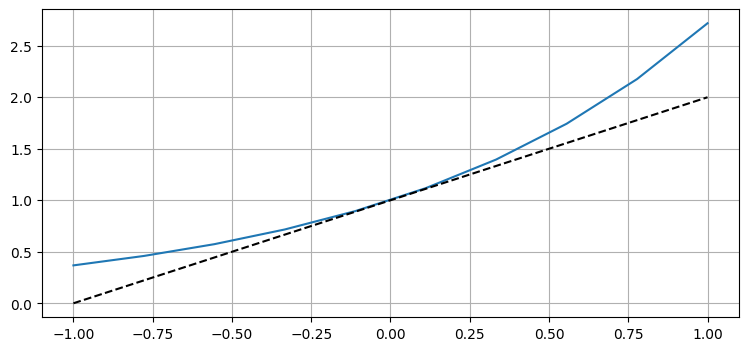

In [14]:
import matplotlib.pyplot as plt

t = np.linspace(-1, 1, 10)
plt.plot(t, np.exp(t))
t = np.linspace(-1, 1, 2)
plt.plot(t,t+1, ls='--', c='k');

你可以看到在 $t=0.1$ 处，斜率非常接近曲线，但在 $t=1$ 处却相距很远。但让我们继续以步长为1进行一会儿。我们可以看到在 $t=1$ 处，$y$ 的估计值为2。现在，我们可以通过计算 $t=1$ 处曲线的斜率，并将其加到我们的初始估计中来计算 $t=2$ 处的值。根据 $y'=y$，在 $t=1$ 处的斜率是2。

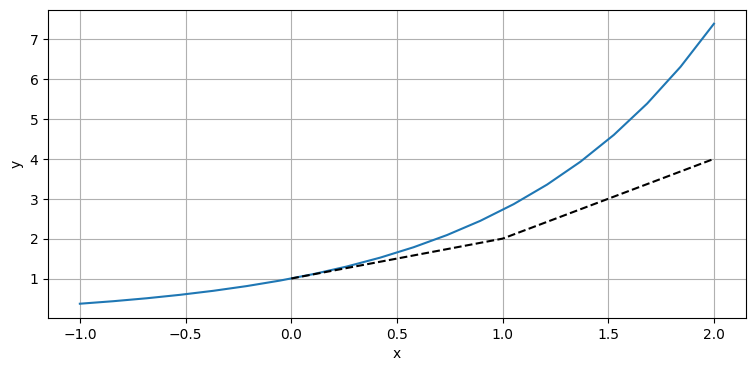

In [15]:
import kf_book.book_plots as book_plots

t = np.linspace(-1, 2, 20)
plt.plot(t, np.exp(t))
t = np.linspace(0, 1, 2)
plt.plot([1, 2, 4], ls='--', c='k')
book_plots.set_labels(x='x', y='y');

这里我们看到下一个 $y$ 的估计值是4。误差迅速变大，可能让你印象不佳。但1是一个非常大的步长。让我们将这个算法编写成代码，并通过使用一个小的步长来验证它是否有效。

In [16]:
def euler(t, tmax, y, dx, step=1.):
    ys = []
    while t < tmax:
        y = y + step*dx(t, y)
        ys.append(y)
        t +=step        
    return ys

In [17]:
def dx(t, y): return y

print(euler(0, 1, 1, dx, step=1.)[-1])
print(euler(0, 2, 1, dx, step=1.)[-1])

2.0
4.0


这看起来是正确的。现在让我们绘制一个更小步长的结果。

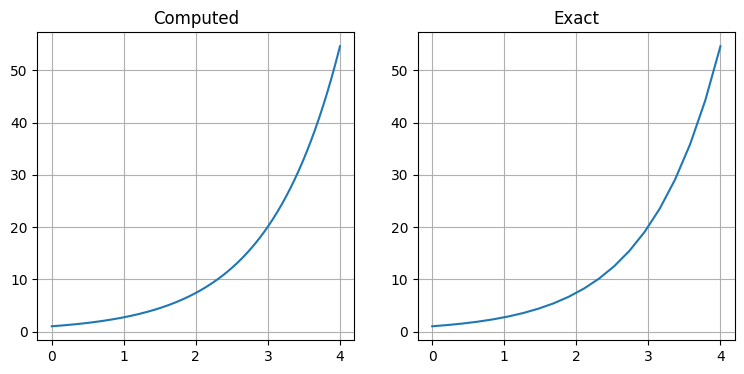

In [18]:
ys = euler(0, 4, 1, dx, step=0.00001)
plt.subplot(1,2,1)
plt.title('Computed')
plt.plot(np.linspace(0, 4, len(ys)),ys)
plt.subplot(1,2,2)
t = np.linspace(0, 4, 20)
plt.title('Exact')
plt.plot(t, np.exp(t));

In [19]:
print('exact answer=', np.exp(4))
print('euler answer=', ys[-1])
print('difference =', np.exp(4) - ys[-1])
print('iterations =', len(ys))

exact answer= 54.598150033144236
euler answer= 54.59705808834125
difference = 0.0010919448029866885
iterations = 400000


在这里，我们可以看到误差相当小，但要达到三位有效数字却需要大量迭代次数。实际上，对于大多数问题，欧拉方法速度太慢了，我们会使用更复杂的方法。

在继续之前，让我们正式推导一下欧拉方法，因为它是下一节中使用的更高级的龙格-库塔方法的基础。事实上，欧拉方法是龙格-库塔方法的最简单形式。

这里是 $y$ 泰勒展开的前三项。无限展开将给出精确答案，所以 $O(h^4)$ 表示由于有限展开而产生的误差。

$$y(t_0 + h) = y(t_0) + h y'(t_0) + \frac{1}{2!}h^2 y''(t_0) + \frac{1}{3!}h^3 y'''(t_0) +  O(h^4)$$

在这里，我们可以看到欧拉方法使用了泰勒展开的前两项。随着项数增加，每个后续项都比前面的项小，所以我们可以确信估计值不会偏离正确值太远。

# 龙格库塔法

龙格-库塔方法是数值积分的主力军。文献中有大量的方法。在实践中，使用我在这里介绍的龙格-库塔算法将能解决你面临的大多数问题。它提供了很好的速度、精度和稳定性平衡，是“常用”的数值积分方法，除非你有非常充分的理由选择其他方法。

让我们深入探讨。我们从某个微分方程开始

$$\ddot{y} = \frac{d}{dt}\dot{y}$$

我们可以用函数 f 替换 y 的导数，就像这样

$$\ddot{y} = \frac{d}{dt}f(y,t)$$.

推导这些方程不在本书的范围之内，但是龙格-库塔 RK4 方法是根据这些方程定义的。

$$y(t+\Delta t) = y(t) + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4) + O(\Delta t^4)$$

$$\begin{aligned}
k_1 &= f(y,t)\Delta t \\
k_2 &= f(y+\frac{1}{2}k_1, t+\frac{1}{2}\Delta t)\Delta t \\
k_3 &= f(y+\frac{1}{2}k_2, t+\frac{1}{2}\Delta t)\Delta t \\
k_4 &= f(y+k_3, t+\Delta t)\Delta t
\end{aligned}
$$

这是相应的代码：

In [20]:
def runge_kutta4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply 
    to compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

让我们用一个简单的例子来演示。

$$\dot{y} = t\sqrt{y(t)}$$

初始值为

$$\begin{aligned}t_0 &= 0\\y_0 &= y(t_0) = 1\end{aligned}$$

max error 0.00005


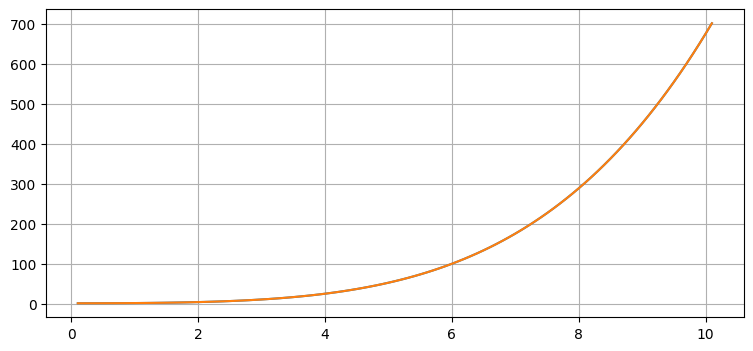

In [21]:
import math
import numpy as np
t = 0.
y = 1.
dt = .1

ys, ts = [], []

def func(y,t):
    return t*math.sqrt(y)

while t <= 10:
    y = runge_kutta4(y, t, dt, func)
    t += dt
    ys.append(y)
    ts.append(t)

exact = [(t**2 + 4)**2 / 16. for t in ts]
plt.plot(ts, ys)
plt.plot(ts, exact)

error = np.array(exact) - np.array(ys)
print(f"max error {max(error):.5f}")

# 贝叶斯滤波

首先，我们讨论贝叶斯滤波。假设我们正在追踪一个物体。我们将其在特定时间的*状态*定义为其位置、速度等。例如，我们可能将时刻 $t$ 的状态写为 $\mathbf x_t = \begin{bmatrix}x_t &\dot x_t \end{bmatrix}^\mathsf T$。

当我们对物体进行测量时，我们实际上是在测量状态或其部分。传感器存在噪声，因此测量结果会受到干扰。但显然，测量是由状态决定的。也就是说，状态的改变可能会导致测量的变化，但测量的改变不会影响状态。

在滤波中，我们的目标是从时间 0 到时间 $t$ 计算一组状态 $\mathbf x_{0:t}$ 的最佳估计。如果我们知道 $\mathbf x_{0:t}$，那么计算与这些状态对应的一组测量 $\mathbf z_{0:t}$ 就会非常容易。但是，我们接收到一组测量 $\mathbf z_{0:t}$，并希望计算相应的状态 $\mathbf x_{0:t}$。这被称为*统计反演*，因为我们试图根据输出来计算输入。

反演是一个困难的问题，因为通常情况下并不存在唯一的解。对于给定的状态 $\mathbf x_{0:t}$，只有一种可能的测量集（加上噪声），但对于给定的测量集，可能有很多不同的状态集可以导致这些测量。

回顾一下贝叶斯定理：

$$P(x \mid z) = \frac{P(z \mid x)P(x)}{P(z)}$$

其中 $P(z \mid x)$ 是测量 $z$ 的*似然*，$P(x)$ 是基于我们的过程模型的*先验*，$P(z)$ 是归一化常数。$P(x \mid z)$ 是*后验*，即在融合测量 $z$ 后的分布，也称为*证据*。

这是一个*统计反演*，因为它从 $P(z \mid x)$ 推导出 $P(x \mid z)$。我们滤波问题的解可以表示为：

$$P(\mathbf x_{0:t} \mid \mathbf z_{0:t}) = \frac{P(\mathbf z_{0:t} \mid \mathbf x_{0:t})P(\mathbf x_{0:t})}{P(\mathbf z_{0:t})}$$

这一切看起来都很好，但是当下一个测量 $\mathbf z_{t+1}$ 来临时，我们需要重新计算整个范围 $0:t+1$ 的表达式。

在实践中，这是不可行的，因为我们试图计算状态 $\mathbf x_{0:t} \mid \mathbf z_{0:t}$ 在所有时间步长上的后验分布。但是我们真的关心第三步（比如说）的概率分布吗，当我们刚收到第十个测量时？通常不关心。因此，我们放宽了要求，只计算当前时间步长的分布。

第一个简化是我们将我们的过程（例如移动物体的运动模型）描述为*马尔可夫链*。也就是说，我们说当前状态仅依赖于上一个状态和一个转移概率 $P(\mathbf x_k \mid \mathbf x_{k-1})$，这只是从上一个状态到当前状态的概率。我们写成：

$$\mathbf x_k \sim P(\mathbf x_k \mid \mathbf x_{k-1})$$

在实践中，这是非常合理的，因为许多事物都具有*马尔可夫性质*。如果你在停车场开车，你在下一秒的位置是否取

决于你一分钟前是从高速公路上下来还是在土路上缓慢行驶？不会。你在下一秒的位置仅取决于你当前的位置、速度和控制输入，而不取决于一分钟前发生了什么。因此，汽车具有马尔可夫性质，我们可以进行这种简化而不会损失精度或泛化性。

我们接下来的简化是将*测量模型*定义为取决于当前状态 $\mathbf x_k$ 的条件测量概率：$P(\mathbf z_k \mid \mathbf x_k)$。我们写成：

$$\mathbf z_k \sim P(\mathbf z_k \mid \mathbf x_k)$$

我们现在有了一个递归，因此我们需要一个初始条件来终止它。因此，我们说初始分布是状态 $\mathbf x_0$ 的概率：

$$\mathbf x_0 \sim P(\mathbf x_0)$$

这些术语被用于贝叶斯公式。如果我们有状态 $\mathbf x_0$ 和第一个测量，我们可以估计 $P(\mathbf x_1 | \mathbf z_1)$。运动模型创建了先验 $P(\mathbf x_2 \mid \mathbf x_1)$。我们将其反馈到贝叶斯定理中，以计算 $P(\mathbf x_2 | \mathbf z_2)$。我们继续这个预测-校正算法，递归地根据时间 $t$ 的状态和分布仅依赖于时间 $t-1$ 的状态和分布以及时间 $t$ 的测量来计算状态和分布。

这种计算的数学细节因问题而异。**离散贝叶斯**和**单变量卡尔曼滤波器**章节提供了两种不同的公式，你应该可以推理出来。单变量卡尔曼滤波器假设对于标量状态，噪声和过程模型都是线性模型，受零均值、不相关高斯噪声的影响。

多变量卡尔曼滤波器做出了相同的假设，但针对状态和测量是矢量而不是标量。卡尔曼博士能够证明，如果这些假设成立，那么卡尔曼滤波器在最小二乘意义上是*最优*的。俗称的意思是无法从嘈杂的测量中获得更多信息。在本书的其余部分，我将介绍放宽线性和高斯噪声约束的滤波器。

在继续之前，关于统计反演还有更多要说。正如 Calvetti 和 Somersalo 在《贝叶斯科学计算导论》中所写的那样，“我们采取了贝叶斯观点：*随机性仅意味着信息的缺乏*”。我们的状态参数化了我们原则上可以测量或计算的物理现象：速度、空气阻力等。我们缺乏足够的信息来计算或测量它们的值，因此我们选择将其视为随机变量。严格来说，它们并不是随机的，因此这是一种主观的观点。

他们在书中专门讨论了这个主题。我可以少说一点。贝叶斯滤波器之所以可能，是因为我们将未知参数的统计性质归因于随机性。在卡尔曼滤波器的情况下，我们有闭式解来找到最优估计。其他滤波器，比如我们在后面一章中介绍的离散贝叶斯滤波器或粒子滤波器，以更加临时、非最优的方式建模概率。我们的技术之所以强大，在于将缺乏信息视为随机变量，并将该随机变量描述为概率分布，然后使用贝叶斯定理来解决统计推断问题。

# 把卡尔曼滤波器转换为 g-h 滤波器

我指出了卡尔曼滤波器是 g-h 滤波器的一种形式。只需要进行一些代数运算就可以证明这一点。在一维情况下更容易证明，所以我将从那里开始。回想一下，

$$
\mu_{x}=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}
$$

我将这个公式写成更容易理解的形式：

$$
\mu_{x}=\frac{ya + xb} {a+b}
$$

我们可以通过以下代数将其转换为 g-h 形式：

$$
\begin{aligned}
\mu_{x}&=(x-x) + \frac{ya + xb} {a+b} \\
\mu_{x}&=x-\frac{a+b}{a+b}x  + \frac{ya + xb} {a+b} \\ 
\mu_{x}&=x +\frac{-x(a+b) + xb+ya}{a+b} \\
\mu_{x}&=x+ \frac{-xa+ya}{a+b}  \\
\mu_{x}&=x+ \frac{a}{a+b}(y-x)\\
\end{aligned}
$$

我们几乎完成了，但回忆一下估计值的方差由以下公式给出：

$$\begin{aligned}
\sigma_{x}^2 &= \frac{1}{\frac{1}{\sigma_1^2} +  \frac{1}{\sigma_2^2}} \\
&= \frac{1}{\frac{1}{a} +  \frac{1}{b}}
\end{aligned}$$

我们可以通过观察到的事实将这个项纳入我们上面的方程中：

$$
\begin{aligned}
\frac{a}{a+b} &= \frac{a/a}{(a+b)/a} = \frac{1}{(a+b)/a}  \\
 &= \frac{1}{1 + \frac{b}{a}} = \frac{1}{\frac{b}{b} + \frac{b}{a}}  \\
 &= \frac{1}{b}\frac{1}{\frac{1}{b} + \frac{1}{a}} \\
 &= \frac{\sigma^2_{x}}{b}
 \end{aligned}
$$

我们可以用以下形式将所有这些联系起来：

$$
\begin{aligned}
\mu_{x}&=x+ \frac{a}{a+b}(y-x) \\
&= x + \frac{\sigma^2_{x}}{b}(y-x) \\
&= x + g_n(y-x)
\end{aligned}
$$

其中

$$
g_n = \frac{\sigma^2_{x}}{\sigma^2_{y}}
$$

最终结果是将两个测量值的残差乘以一个常数，并加到先前的值上，这是 g-h 滤波器的 $g$ 方程。$g$ 是新估计的方差与测量值的方差之比。当然，在这种情况下，$g$ 不是一个常数，因为它随着方差的变化而变化。我们也可以以同样的方式推导出 $h$ 的公式。这不是一个特别启发式的推导，我会跳过。最终结果是

$$
h_n = \frac{COV (x,\dot x)}{\sigma^2_{y}}
$$

要点是 $g$ 和 $h$ 完全由时间 $n$ 的测量和预测的方差和协方差指定。换句话说，我们通过两个输入的质量来确定测量和预测之间的某个点。

# 参考

 * [1] C.B. Molwer and C.F. Van Loan "Nineteen Dubious Ways to Compute the Exponential of a Matrix, Twenty-Five Years Later,", *SIAM Review 45, 3-49*. 2003.


 * [2] C.F. van Loan, "Computing Integrals Involving the Matrix Exponential," IEEE *Transactions Automatic Control*, June 1978.
 
 
 * [3] Calvetti, D and Somersalo E, "Introduction to Bayesian Scientific Computing: Ten Lectures on Subjective Computing,", *Springer*, 2007.
 
 * [4] Brown, R. G. and Hwang, P. Y.C., "Introduction to Random Signals and Applied Kalman Filtering", *Wiley and Sons*, Fourth Edition, p.143-147, 2012. 